## Analysis of the Relationship Between the Number of Communicable Disease Cases in NYC and Temperature Anomalies from 2000-2016
## Fall 2018 'Researching Computing in Earth Sciences' Final Project
### By: Stephanie Stettz 

#### I used the following datasets to conduct this analysis:
####      - NCAR monthly temperature data
####      - Communicable disease records from 2000 to 2016

#### A communicable disease is spread from one person to another through contact with blood and bodily fluids; breathing in an airborne virus, or by being bitten by disease-carrying vectors (e.g. insects).

#### Communicable disease cases are reported to the Bureau of Communicable Disease of the NYC Department of Health and Mental Hygiene (DOHMH).  The dataset can be found on the New York City Open Data Website (https://data.cityofnewyork.us/Health/Communicable-Disease-Surveillance-Data/gff2-veif)


In [154]:
# import packages 
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

## Part I: Communicable Disease Dataset


In [155]:
# download and organize disease data
! wget https://data.cityofnewyork.us/api/views/gff2-veif/rows.csv

--2018-12-06 04:35:46--  https://data.cityofnewyork.us/api/views/gff2-veif/rows.csv
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv.1’

rows.csv.1              [ <=>                ] 386.94K  --.-KB/s    in 0.1s    

Last-modified header invalid -- time-stamp ignored.
2018-12-06 04:35:46 (3.17 MB/s) - ‘rows.csv.1’ saved [396230]



### I first renamed certain columns for easier access to the data.

In [156]:
# save data in pandas array
diseases = pd.read_csv('rows.csv')
diseases.head()

diseases=diseases.rename(index=str,columns={'Case Count': 'Case_Count',
                                            'Crude Rate per 100,000 Population':'Crude_rate',
                                           'Age-Adjusted Rate per 100,000 Population':'Age_Adj_rate'})
diseases.head()

,Year,Disease,Neighborhood,Case_Count,Crude_rate,Age_Adj_rate
0,2004,Acute hepatitis B,101 Kingsbridge - Riverdale,1,1.1,1.0
1,2004,Acute hepatitis B,102 Northeast Bronx,2,1.1,1.0
2,2004,Acute hepatitis B,103 Fordham - Bronx Park,3,1.2,1.5
3,2004,Acute hepatitis B,104 Pelham - Throgs Neck,9,3.1,3.1
4,2004,Acute hepatitis B,105 Crotona - Tremont,3,1.5,1.6


### Below is a list of the ten communicable diseases recorded in this dataset:

In [157]:
disease_names=diseases.groupby('Disease')
list(disease_names.groups.keys())

['Acute hepatitis B',
 'Chronic hepatitis C',
 'Cryptosporidiosis',
 'Legionellosis',
 'Lyme disease',
 'Malaria',
 'Meningococcal disease, invasive',
 'Salmonellosis',
 'Streptococcus pneumoniae, invasive',
 'West Nile disease']

### From 2000-2016, we can see chronic hepatitis C was the most common communicable disease recorded in New York City (Fig 1a).   2007 had the largest number of recorded communicable disease cases (Fig 1b).

Text(0.5,1,'1b. Number of Cases per Year')

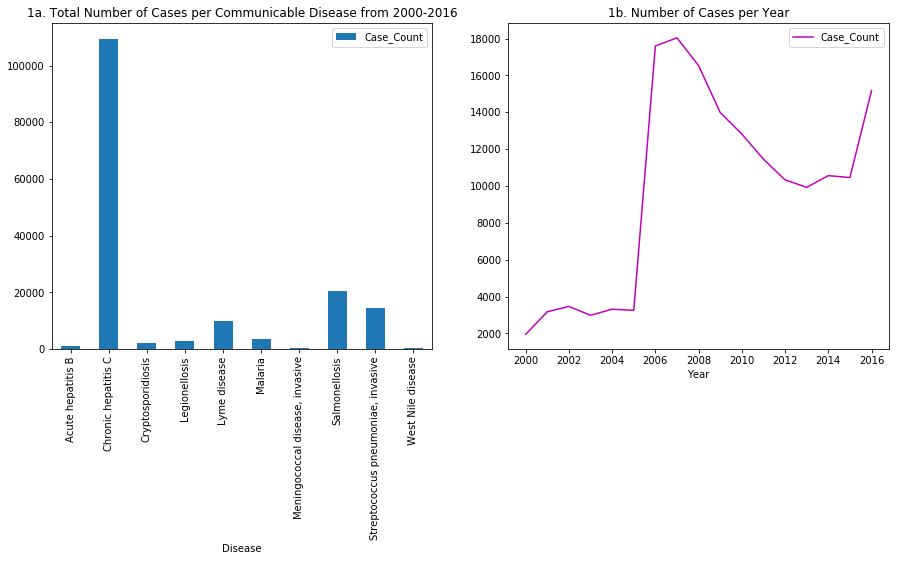

In [158]:
# sort data by disease type 
disease_type = diseases.set_index('Disease')
fig, ax = plt.subplots(ncols=2,figsize=(15,6))
disease_type.groupby('Disease').aggregate({'Case_Count':sum}).plot(ax=ax[0],kind='bar')
ax[0].set_title('1a. Total Number of Cases per Communicable Disease from 2000-2016')
# first plot shows total number of cases over 12 years
diseases.groupby('Year').aggregate({'Case_Count':sum}).plot(ax=ax[1],kind='line',color='m')
ax[1].set_title('1b. Number of Cases per Year')
# second plot shows the total number of cases per year

### I then wanted to group the disease counts by year, to see how many cases of each disease there were per year, which I then plotted in bar plots (Fig 2).

### One issue I had was trying to create subplots so the graphs were next to each other instead of in one large column, so it would be easier to look at. 

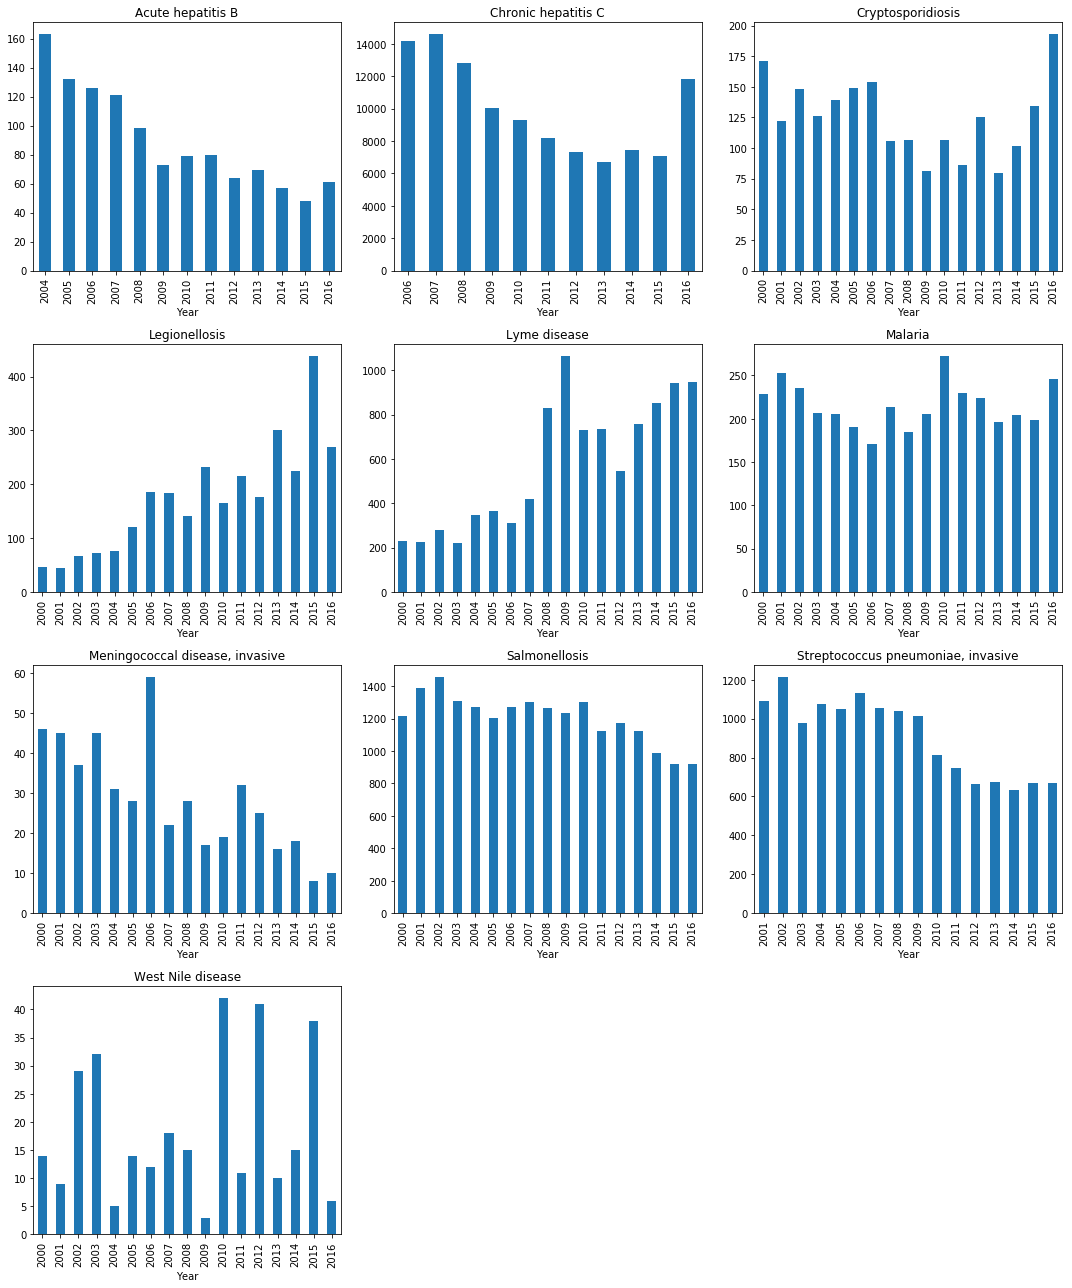

In [159]:
all_names=list(disease_names.groups.keys())
ds_group=diseases.set_index('Disease')

fig = plt.figure(figsize=(15,18))
# loop to create plots for each disease type
for i,ind in zip(all_names, range(1,11)):
    ax = fig.add_subplot(4,3,ind)
    ds_group.loc[i].groupby('Year').aggregate({'Case_Count':sum}).plot(ax=ax,kind='bar',title=i,legend=False)

plt.tight_layout()
plt.show()


### Some interesting things to note:
### - Lyme disease and Legionellosis (pneumonia) seem to have an increase in the number of recorded cases as time progresses.
### - Meningococcal meningitis, Strep throat, and Salmonella appear to have a slight decrease in the number of recorded cases over time. 
### - Hepatitis B & C overall seem to have been decreasing over time (except for 2016). However it appears that maybe cases were not recorded (or data is missing) prior to 2004.  
### - Cryptosporidiosis (a diarrheal disease), West Nile and Malaria do not appear to have any sort of trend.  

## Part II: Incorporating Monthly Temperature Data

#### I obtained the NOAA NCEP-NCAR CDAS-1 Monthly temperature data from the IRI Data Library. (https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/)

In [160]:
# import temperature data from IRI library 
# link: 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Diagnostic/.surface/.temp/dods'
dtemp = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Diagnostic/.surface/.temp/dods',decode_times=False)
dtemp

<xarray.Dataset>
Dimensions:  (T: 839, X: 192, Y: 94)
Coordinates:
  * Y        (Y) float32 88.54196 86.65315 84.75323 82.85076 80.94736 ...
  * X        (X) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * T        (T) float32 -131.5 -130.5 -129.5 -128.5 -127.5 -126.5 -125.5 ...
Data variables:
    temp     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

#### Here I used the trick discussed in class to get the time coordinate as a datetime.

In [161]:
import cftime
cftime.__version__
# define function to fix calendar issue 
def fix_calendar(dtemp, timevar='T'):
    if dtemp[timevar].attrs['calendar'] == '360':
        dtemp[timevar].attrs['calendar'] = '360_day'
    return dtemp

dtemp = fix_calendar(dtemp)
dtemp = xr.decode_cf(dtemp)
dtemp

<xarray.Dataset>
Dimensions:  (T: 839, X: 192, Y: 94)
Coordinates:
  * Y        (Y) float32 88.54196 86.65315 84.75323 82.85076 80.94736 ...
  * X        (X) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * T        (T) datetime64[ns] 1949-01-16 1949-02-16 1949-03-16 1949-04-16 ...
Data variables:
    temp     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

### Then I calculate a running mean to determine the monthly temperature anomaly: 

In [162]:
# calculate running mean 
def remove_time_mean(x):
    return x - x.mean(dim='T')

dt_anom = dtemp.groupby('T.month').apply(remove_time_mean)
dt_anom

<xarray.Dataset>
Dimensions:  (T: 839, X: 192, Y: 94)
Coordinates:
  * Y        (Y) float32 88.54196 86.65315 84.75323 82.85076 80.94736 ...
  * X        (X) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * T        (T) datetime64[ns] 1949-01-16 1949-02-16 1949-03-16 1949-04-16 ...
Data variables:
    temp     (T, Y, X) float32 -7.530716 -7.507324 -7.4995728 -7.49469 ...
    month    (T) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12 ...

### Below I plotted the monthly temperature anomaly, as well as a 1 year resample and a 12-month running mean for New York City (Fig 3). 

In [163]:
dt_anom_resample = dt_anom.resample(T='Y').mean(dim='T')
#dt_anom_resample

In [164]:
dt_anom_rolling = dt_anom.rolling(T=12, center=True).mean()
#dt_anom_rolling

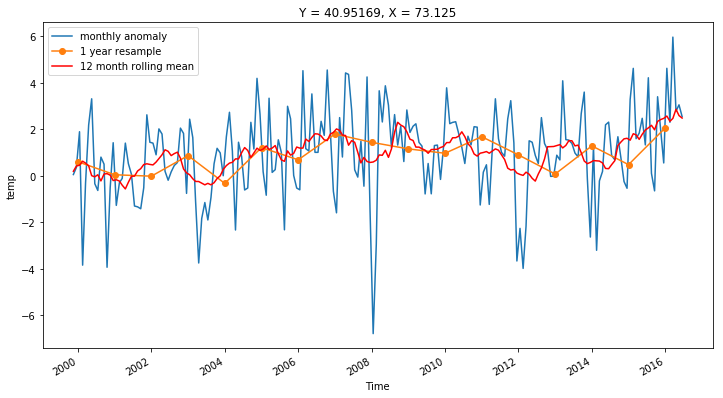

In [165]:
fig, ax = plt.subplots(figsize=(12,6))
dt_anom.temp.isel(X=39, Y=25,T=slice(610,810)).plot(label='monthly anomaly')
dt_anom_resample.temp.isel(X=39, Y=25,T=slice(50,67)).plot(marker='o', label='1 year resample')
dt_anom_rolling.temp.isel(X=39, Y=25,T=slice(610,810)).plot(color='r',label='12 month rolling mean')
plt.legend()

### Since there was the largest number of communicable disease cases in 2007, I wanted to see what the monthly temperature anomalies were for this year. So I created plots to show summer (August) and Winter (December) monthly temperature anomalies (Fig 4). 

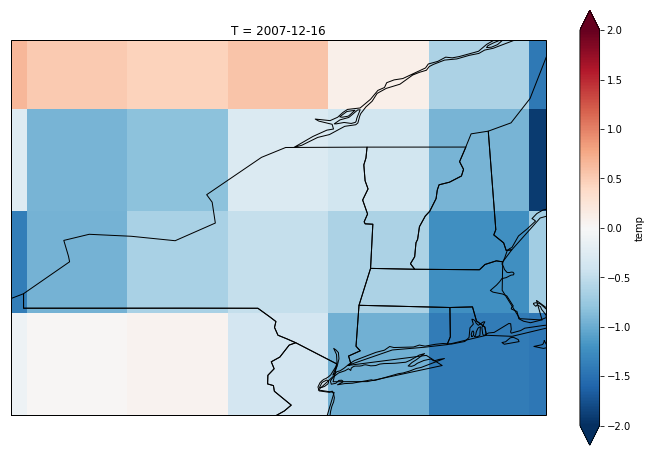

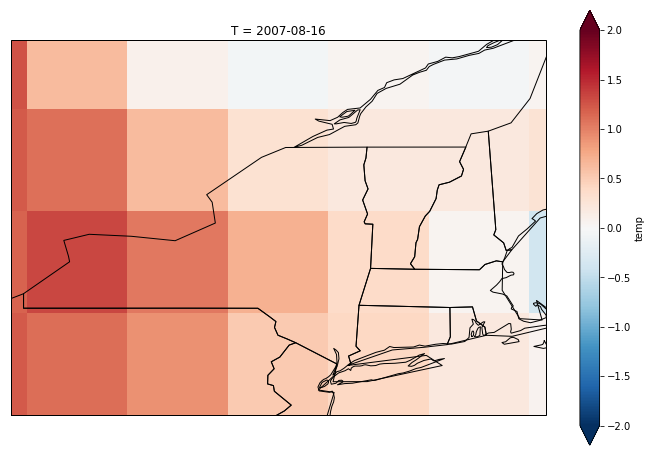

In [166]:
central_lat = 37.5
central_lon = -96
extent = [-80, -70, 40, 47]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
# December 2007 Figure 
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.STATES)
proj = ccrs.PlateCarree() 
# plot temperature data onto map 
dt_anom.temp.sel(T='2007-12-16').plot(ax=ax, transform=proj,cmap='RdBu_r', vmin=-2, vmax=2)
ax.set_extent(extent)
# July 2007 Figure 
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.STATES)
proj = ccrs.PlateCarree() 
# plot temperature data onto map 
dt_anom.temp.sel(T='2007-08-16').plot(ax=ax, transform=proj,cmap='RdBu_r', vmin=-2, vmax=2)
ax.set_extent(extent)

#### New York City had a negative temperature anomaly in December (~-1 deg C) and a positive anomaly in August (~0.5 C) of 2007. However, looking at the number of recorded cases, Chronic hepatitis C (which is spread through contact with infected blood) was the most frequently recorded disease during this year (Fig 5).  Since the disease is spread through blood contact, the large amount of cases can't be attributed to air temperature, but is likely related to another cause.  

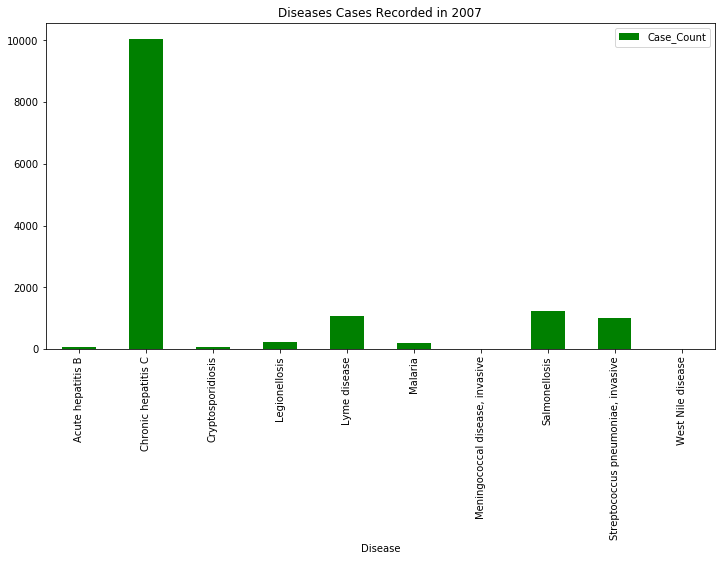

In [167]:
# create plot of disease cases just for 2007
fig, ax = plt.subplots(figsize=(12,6))
year_2007 = diseases.set_index('Year')
year_2007.loc[2009].groupby('Disease').aggregate({'Case_Count':sum}).plot(ax=ax,kind='bar',color='g',title='Diseases Cases Recorded in 2007')

## Part III: Calculating Correlation & Covariance

### I first attempted a simple correlation calculation between the total number of disease cases and the resampled temperature anomaly. Below are the functions I used to do these calculations:

In [168]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [169]:
# set variables of interest to x1 (total disease counts) and y1 (resampled 1 year temperature anomalies)
ds_total=diseases.groupby('Year').aggregate({'Case_Count':sum})
ds_total_xr=ds_total.to_xarray()
x=ds_total_xr.Case_Count
y=dt_anom_resample.temp.isel(X=39, Y=25,T=slice(50,67))

R-squared: 0.3798344245532756 p-value: 0.008423208158496103


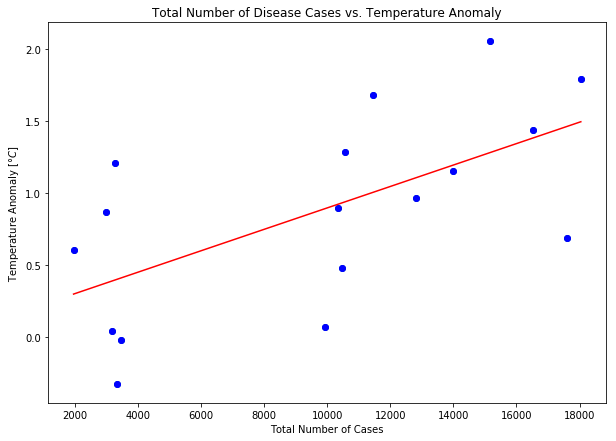

In [170]:
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(x,y)
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,17)
y1=gradient*x1+intercept
plt.plot(x,y,'ob')
plt.plot(x1,y1,'-r')
ax.set_xlabel('Total Number of Cases')
ax.set_ylabel('Temperature Anomaly [$\degree C]$')
ax.set_title('Total Number of Disease Cases vs. Temperature Anomaly')
print('R-squared:', r_value**2, 'p-value:',p_value)

### The R-squared and linear fit seen in the figure (Fig 6) would suggest a positive relationship,and the the p-value<0.05 (p=0.008), so we can reject the null hypothesis.

### I then calculated the correlation between the resampled temperature anomalies and the total number of a.) Legionellosis (pneumonia) and b.)Meningococcal disease cases (Fig 7).  I chose these two diseases because they either had an relative increase or decrease in the number of recorded cases over the time period. 

### There have already been studies that have shown that lyme disease cases have increased due to increasing temperatures, so I wanted to consider other diseases. (https://www.scientificamerican.com/article/has-climate-change-made-lyme-disease-worse/)

R-squared (Legionellosis): 0.07233717530280227 p-value (Legionellosis): 0.29655083573587915
R-squared (Meningococcal disease): 0.10945460098526506 p-value (Meningococcal disease): 0.19460420283241356


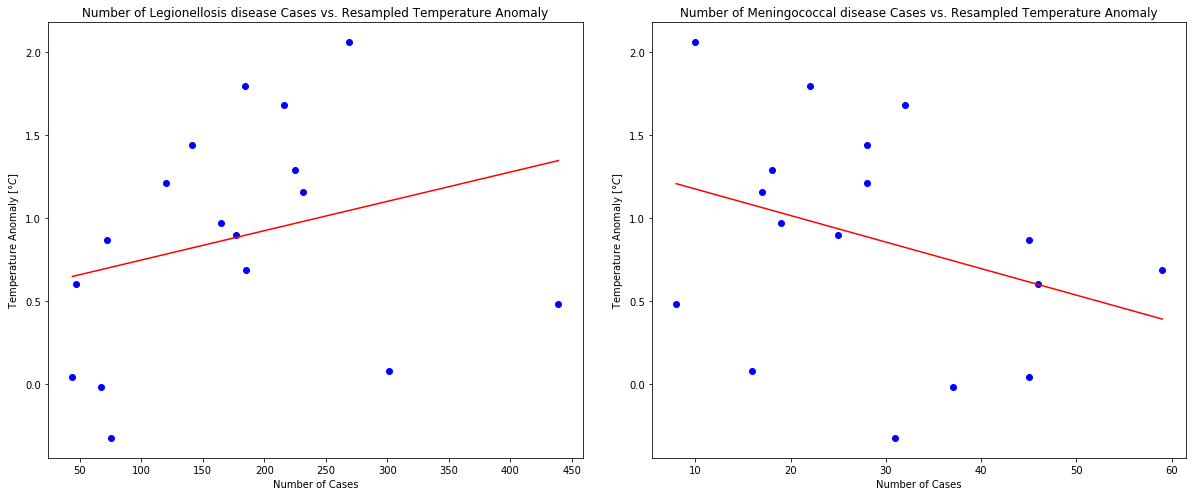

In [171]:
# Figure 7a
ds_dis = ds_group.loc['Legionellosis'].groupby('Year').aggregate({'Case_Count':sum})
ds_dis=ds_dis.to_xarray()
x = ds_dis.Case_Count
y=dt_anom_resample.temp.isel(X=39, Y=25,T=slice(50,67))
fig, ax = plt.subplots(ncols=2,figsize=(17,7))
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,17)
y1=gradient*x1+intercept
ax[0].plot(x,y,'ob')
ax[0].plot(x1,y1,'-r')
ax[0].set_xlabel('Number of Cases')
ax[0].set_ylabel('Temperature Anomaly [$\degree C]$')
ax[0].set_title('Number of Legionellosis disease Cases vs. Resampled Temperature Anomaly')
print('R-squared (Legionellosis):', r_value**2, 'p-value (Legionellosis):',p_value)
## Figure 7b
ds_dis = ds_group.loc['Meningococcal disease, invasive'].groupby('Year').aggregate({'Case_Count':sum})
ds_dis=ds_dis.to_xarray()
x = ds_dis.Case_Count
y=dt_anom_resample.temp.isel(X=39, Y=25,T=slice(50,67))
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,17)
y1=gradient*x1+intercept
ax[1].plot(x,y,'ob')
ax[1].plot(x1,y1,'-r')
ax[1].set_xlabel('Number of Cases')
ax[1].set_ylabel('Temperature Anomaly [$\degree C]$')
ax[1].set_title('Number of Meningococcal disease Cases vs. Resampled Temperature Anomaly')
print('R-squared (Meningococcal disease):', r_value**2, 'p-value (Meningococcal disease):',p_value)
plt.tight_layout()
plt.show()

#### Just looking at the plots, there appears to be a positive correlation between Legionellosis cases and air temperature anomalies (warmer air temperatures means more cases), and a negative correlation between temperature anomalies and Meningococcal disease cases (colder temperatures, more cases).  However both had p-values > 0.05, so neither is conclusive. 

#### "Legionellosis pneumonia doesn't spread from person to person. Instead, the bacteria spreads in the air through mist, such as from air-conditioning units for large buildings." This could explain the possible positive trend seen in the graph (warmer temperatures = more air conditioning).  

#### Meningococcal disease in spread through saliva or spit, so direct contact with people is needed.  People spend more time indoors during the cold, winter months, increasing human contact and therefore potentially increasing the number of cases. 

## Part IV: Conclusions, Caveats & Future Work

#### Looking at any disease alone, there does not appear to be strong trends between air temperature anomalies and the number of cases.  However, if you consider all ten of these communicable diseases, there does appear to be a positive correlation between warmer temperatures and increased observed cases.

#### This analysis is dependent on the number of recorded cases.  It is possible (and most likely) that more cases occurred that were just not recorded.  It is also important to keep in mind that other social factors may account for the changes in the number of cases we see overtime. 

#### One issue I ran into was with the disease case data.  Some diseases had better records than others, so sometimes that I had difficulties when trying to generate plots.  I also had a little difficulty when indexing the temperature data for the approximate lat/lon of New York City. 

### Other Notes/Tidbits 

#### Hepatitis B & C are spread through contact with infected blood. Hepatitis B has been on the decline since the launch of the vaccine in 1991, which explains the trend observed in the figure.
#### The uptick in Hepatitis C cases observed in 2016 may be due to the drug crisis being seen in many portions of the United States. (https://www.politico.com/states/new-york/city-hall/story/2016/02/new-cases-of-hepatitis-c-in-nyc-are-on-the-rise-000000)


#### West Nile, Malaria, and Lyme disease are vector-borne diseases.Vectors are more influenced by temperatures.